In [ ]:
import joblib
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd

# Tải mô hình

Chọn ra mô hình có hiệu suất tốt nhất, trong đó RandomForest, CatBoost và Stacking có hiệu suất cao. Dùng các mô hình đã liệt kê để dự đoán

In [ ]:
!pip install catboost

In [ ]:
rf = joblib.load('RandomForest')
cb = joblib.load('CatBoost')
st = joblib.load('Stacking')
print("Tải mô hình thành công!")

Tải mô hình thành công!


# Chuẩn bị mẫu để dự đoán

Vì không có dữ liệu ngoài, nên sẽ sử dụng chính tập dữ liệu thô như tập dự đoán để kiểm tra, đánh giá khả năng dự đoán của mô hình.

Tập dự đoán này cần được trải qua tiền xử lý tương tự với tiền xử lý dữ liệu huấn luyện của mô hình. Áp dụng tính toán dữ liệu qua số liệu của tập dự đoán, không phải tập huấn luyện.

In [ ]:
df = pd.read_csv('diabetes.csv')

In [ ]:
dfCopy = df.copy()

In [ ]:
df

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
0,6,148,72,35,0,33.6,0.627,50,1
1,1,85,66,29,0,26.6,0.351,31,0
2,8,183,64,0,0,23.3,0.672,32,1
3,1,89,66,23,94,28.1,0.167,21,0
4,0,137,40,35,168,43.1,2.288,33,1
...,...,...,...,...,...,...,...,...,...
763,10,101,76,48,180,32.9,0.171,63,0
764,2,122,70,27,0,36.8,0.340,27,0
765,5,121,72,23,112,26.2,0.245,30,0
766,1,126,60,0,0,30.1,0.349,47,1


In [ ]:
numerical_columns = ['Pregnancies', 'Glucose', 'BloodPressure', 'SkinThickness', 'Insulin', 'BMI', 'DiabetesPedigreeFunction', 'Age']
features = ['Glucose', 'BloodPressure','SkinThickness','Insulin','BMI','Age']
for feature in features:
    df[feature] = df[feature].apply(lambda x: np.nan if x <= 0 else x)

In [ ]:
df_1 = df[df['Outcome'] == 1]
df_0 = df[df['Outcome'] == 0]

median_1 = df_1.median()
median_0 = df_0.median()

df[df['Outcome']==1] = df_1.fillna(median_1)
df[df['Outcome']==0] = df_0.fillna(median_0)

for col in numerical_columns:
    df[col] = df[col].astype(dfCopy[col].dtype)

In [ ]:
df

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
0,6,148,72,35,169,33.6,0.627,50,1
1,1,85,66,29,102,26.6,0.351,31,0
2,8,183,64,32,169,23.3,0.672,32,1
3,1,89,66,23,94,28.1,0.167,21,0
4,0,137,40,35,168,43.1,2.288,33,1
...,...,...,...,...,...,...,...,...,...
763,10,101,76,48,180,32.9,0.171,63,0
764,2,122,70,27,102,36.8,0.340,27,0
765,5,121,72,23,112,26.2,0.245,30,0
766,1,126,60,32,169,30.1,0.349,47,1


In [ ]:
def remove_outliers(df, column):
    outliersIndex = set()
    for features in column:
      Q1 = df[features].quantile(0.25)
      Q3 = df[features].quantile(0.75)
      IQR = Q3 - Q1
      lower_bound = Q1 - 1.5 * IQR
      upper_bound = Q3 + 1.5 * IQR
      outliersFFeature = df[(df[features] < lower_bound) | (df[features] > upper_bound)].index.to_list()
      outliersIndex = outliersIndex.union(set(outliersFFeature))
    return df.drop(list(outliersIndex))

df = remove_outliers(df, numerical_columns)

In [ ]:
df

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
0,6,148,72,35,169,33.6,0.627,50,1
1,1,85,66,29,102,26.6,0.351,31,0
2,8,183,64,32,169,23.3,0.672,32,1
3,1,89,66,23,94,28.1,0.167,21,0
5,5,116,74,27,102,25.6,0.201,30,0
...,...,...,...,...,...,...,...,...,...
762,9,89,62,27,102,22.5,0.142,33,0
764,2,122,70,27,102,36.8,0.340,27,0
765,5,121,72,23,112,26.2,0.245,30,0
766,1,126,60,32,169,30.1,0.349,47,1


In [ ]:
df_x = df.drop('Outcome', axis=1)
raw_x = dfCopy.drop('Outcome', axis=1)

Mẫu để dự đoán sẽ là tập dữ liệu thô và tập dữ liệu đã được xử lý dựa trên sự tính toán của chính tập dữ liệu.

Xong phần tạo mẫu, tiến đến phần dự đoán

# Dự đoán mẫu

## RandomForest

Processed Data

     Pregnancies  Glucose  BloodPressure  SkinThickness  Insulin   BMI  \
0              6      148             72             35      169  33.6   
1              1       85             66             29      102  26.6   
2              8      183             64             32      169  23.3   
3              1       89             66             23       94  28.1   
5              5      116             74             27      102  25.6   
..           ...      ...            ...            ...      ...   ...   
762            9       89             62             27      102  22.5   
764            2      122             70             27      102  36.8   
765            5      121             72             23      112  26.2   
766            1      126             60             32      169  30.1   
767            1       93             70             31      102  30.4   

     DiabetesPedigreeFunction  Age  Outcome  Prediction  
0                       0.627   50        1          

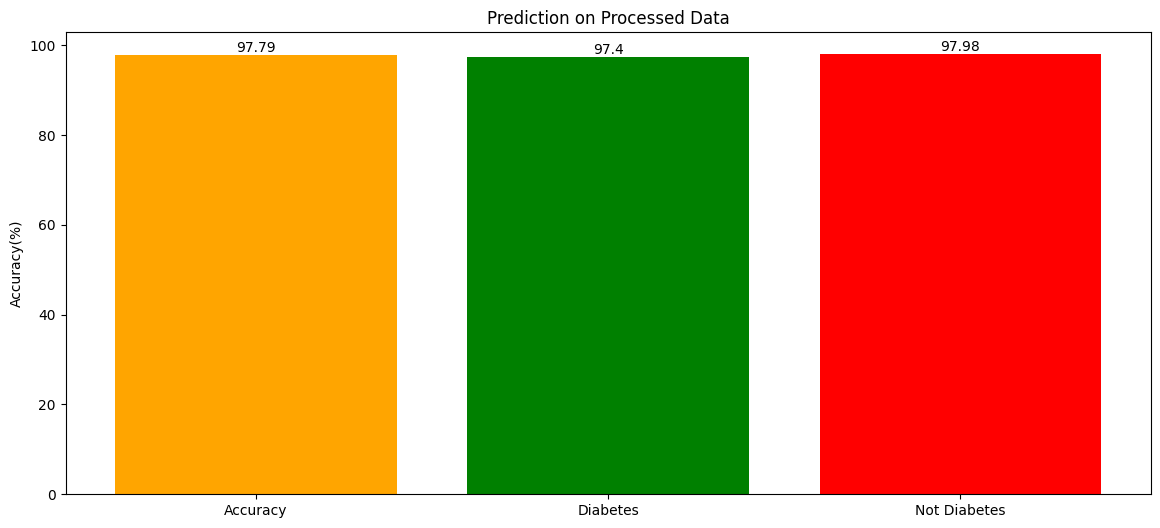

In [ ]:
y_proba = rf.predict_proba(df_x)[:, 1]
y_pred = (y_proba >= 0.6).astype(int)

df['Prediction'] = y_pred
print(df)
accuracy = (((df['Prediction'] == df['Outcome']).sum()/df.shape[0])*100).round(2)
accuracy_1 = ((((df['Prediction']==1) & (df['Outcome']==1)).sum()/(df['Outcome']==1).sum())*100).round(2)
accuracy_0 = ((((df['Prediction']==0) & (df['Outcome']==0)).sum()/(df['Outcome']==0).sum())*100).round(2)

# Accuracy is float, need to put it in [] instead of keys(), values()
plt.figure(figsize=(14,6))
bar = plt.bar(['Accuracy'],[accuracy],color='orange')
plt.bar_label(bar)
bar_1 = plt.bar(['Diabetes'],[accuracy_1],color='green')
plt.bar_label(bar_1)
bar_0 = plt.bar(['Not Diabetes'],[accuracy_0],color='red')
plt.bar_label(bar_0)
plt.title('Prediction on Processed Data')
plt.ylabel('Accuracy(%)')
plt.show()

Raw Data

     Pregnancies  Glucose  BloodPressure  SkinThickness  Insulin   BMI  \
0              6      148             72             35        0  33.6   
1              1       85             66             29        0  26.6   
2              8      183             64              0        0  23.3   
3              1       89             66             23       94  28.1   
4              0      137             40             35      168  43.1   
..           ...      ...            ...            ...      ...   ...   
763           10      101             76             48      180  32.9   
764            2      122             70             27        0  36.8   
765            5      121             72             23      112  26.2   
766            1      126             60              0        0  30.1   
767            1       93             70             31        0  30.4   

     DiabetesPedigreeFunction  Age  Outcome  Prediction  
0                       0.627   50        1          

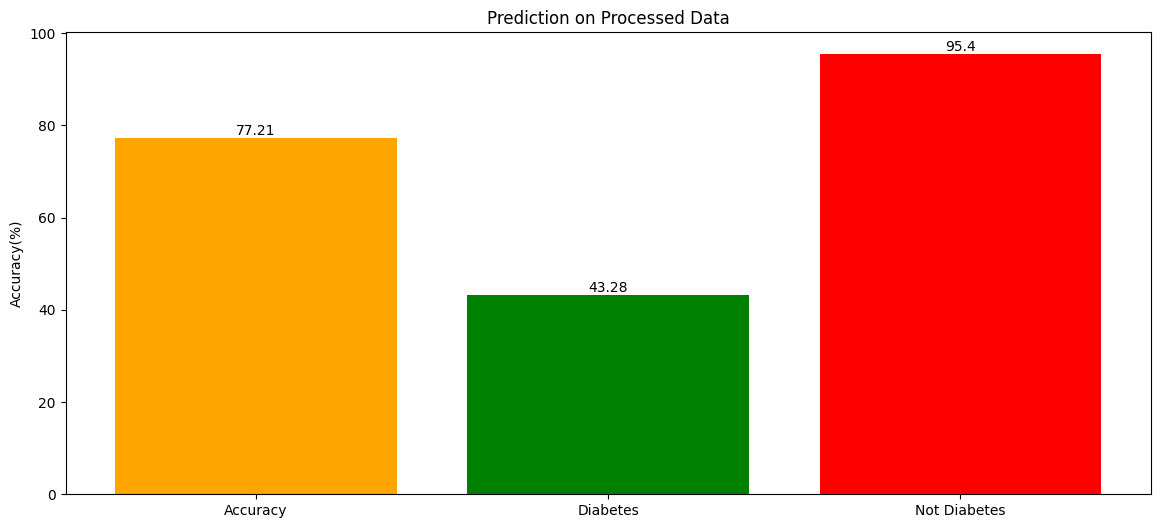

In [ ]:
y_proba = rf.predict_proba(raw_x)[:, 1]
y_pred = (y_proba >= 0.6).astype(int)

dfCopy['Prediction'] = y_pred
print(dfCopy)
accuracy = (((dfCopy['Prediction'] == dfCopy['Outcome']).sum()/dfCopy.shape[0])*100).round(2)
accuracy_1 = ((((dfCopy['Prediction']==1) & (dfCopy['Outcome']==1)).sum()/(dfCopy['Outcome']==1).sum())*100).round(2)
accuracy_0 = ((((dfCopy['Prediction']==0) & (dfCopy['Outcome']==0)).sum()/(dfCopy['Outcome']==0).sum())*100).round(2)

# Accuracy is float, need to put it in [] instead of keys(), values()
plt.figure(figsize=(14,6))
bar = plt.bar(['Accuracy'],[accuracy],color='orange')
plt.bar_label(bar)
bar_1 = plt.bar(['Diabetes'],[accuracy_1],color='green')
plt.bar_label(bar_1)
bar_0 = plt.bar(['Not Diabetes'],[accuracy_0],color='red')
plt.bar_label(bar_0)
plt.title('Prediction on Processed Data')
plt.ylabel('Accuracy(%)')
plt.show()

## CatBoost

Processed Data

     Pregnancies  Glucose  BloodPressure  SkinThickness  Insulin   BMI  \
0              6      148             72             35      169  33.6   
1              1       85             66             29      102  26.6   
2              8      183             64             32      169  23.3   
3              1       89             66             23       94  28.1   
5              5      116             74             27      102  25.6   
..           ...      ...            ...            ...      ...   ...   
762            9       89             62             27      102  22.5   
764            2      122             70             27      102  36.8   
765            5      121             72             23      112  26.2   
766            1      126             60             32      169  30.1   
767            1       93             70             31      102  30.4   

     DiabetesPedigreeFunction  Age  Outcome  Prediction  
0                       0.627   50        1          

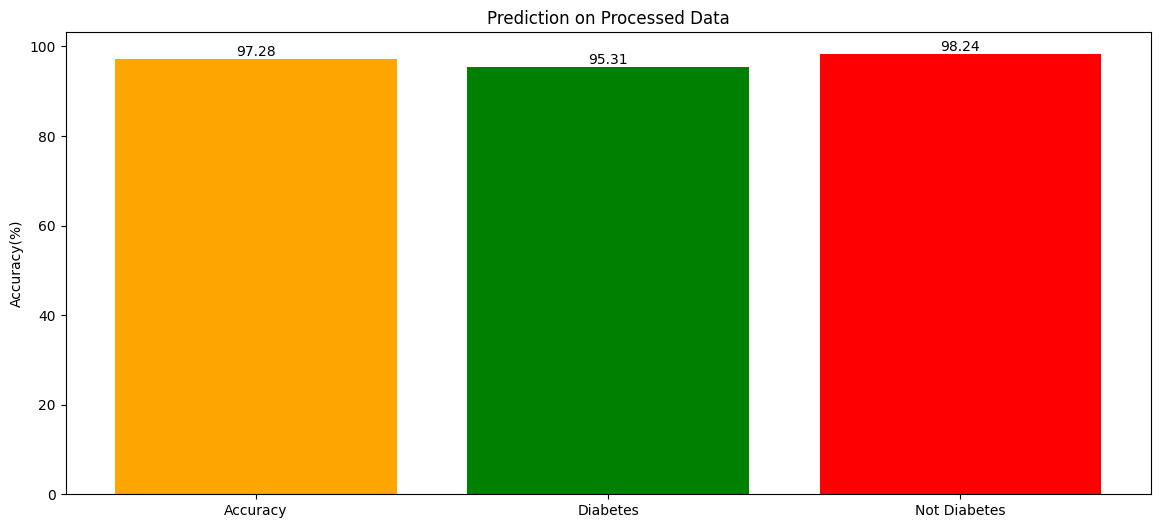

In [ ]:
y_proba = cb.predict_proba(df_x)[:, 1]
y_pred = (y_proba >= 0.7).astype(int)

df['Prediction'] = y_pred
print(df)
accuracy = (((df['Prediction'] == df['Outcome']).sum()/df.shape[0])*100).round(2)
accuracy_1 = ((((df['Prediction']==1) & (df['Outcome']==1)).sum()/(df['Outcome']==1).sum())*100).round(2)
accuracy_0 = ((((df['Prediction']==0) & (df['Outcome']==0)).sum()/(df['Outcome']==0).sum())*100).round(2)

# Accuracy is float, need to put it in [] instead of keys(), values()
plt.figure(figsize=(14,6))
bar = plt.bar(['Accuracy'],[accuracy],color='orange')
plt.bar_label(bar)
bar_1 = plt.bar(['Diabetes'],[accuracy_1],color='green')
plt.bar_label(bar_1)
bar_0 = plt.bar(['Not Diabetes'],[accuracy_0],color='red')
plt.bar_label(bar_0)
plt.title('Prediction on Processed Data')
plt.ylabel('Accuracy(%)')
plt.show()

Raw Data

     Pregnancies  Glucose  BloodPressure  SkinThickness  Insulin   BMI  \
0              6      148             72             35        0  33.6   
1              1       85             66             29        0  26.6   
2              8      183             64              0        0  23.3   
3              1       89             66             23       94  28.1   
4              0      137             40             35      168  43.1   
..           ...      ...            ...            ...      ...   ...   
763           10      101             76             48      180  32.9   
764            2      122             70             27        0  36.8   
765            5      121             72             23      112  26.2   
766            1      126             60              0        0  30.1   
767            1       93             70             31        0  30.4   

     DiabetesPedigreeFunction  Age  Outcome  Prediction  
0                       0.627   50        1          

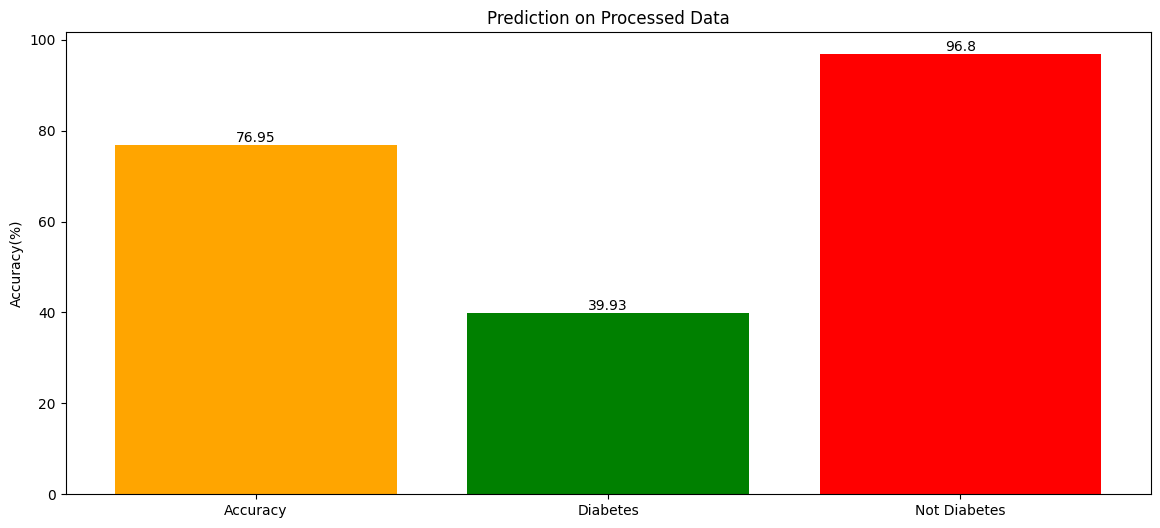

In [ ]:
y_proba = cb.predict_proba(raw_x)[:, 1]
y_pred = (y_proba >= 0.7).astype(int)

dfCopy['Prediction'] = y_pred
print(dfCopy)
accuracy = (((dfCopy['Prediction'] == dfCopy['Outcome']).sum()/dfCopy.shape[0])*100).round(2)
accuracy_1 = ((((dfCopy['Prediction']==1) & (dfCopy['Outcome']==1)).sum()/(dfCopy['Outcome']==1).sum())*100).round(2)
accuracy_0 = ((((dfCopy['Prediction']==0) & (dfCopy['Outcome']==0)).sum()/(dfCopy['Outcome']==0).sum())*100).round(2)

# Accuracy is float, need to put it in [] instead of keys(), values()
plt.figure(figsize=(14,6))
bar = plt.bar(['Accuracy'],[accuracy],color='orange')
plt.bar_label(bar)
bar_1 = plt.bar(['Diabetes'],[accuracy_1],color='green')
plt.bar_label(bar_1)
bar_0 = plt.bar(['Not Diabetes'],[accuracy_0],color='red')
plt.bar_label(bar_0)
plt.title('Prediction on Processed Data')
plt.ylabel('Accuracy(%)')
plt.show()

## Stacking

Processed Data

     Pregnancies  Glucose  BloodPressure  SkinThickness  Insulin   BMI  \
0              6      148             72             35      169  33.6   
1              1       85             66             29      102  26.6   
2              8      183             64             32      169  23.3   
3              1       89             66             23       94  28.1   
5              5      116             74             27      102  25.6   
..           ...      ...            ...            ...      ...   ...   
762            9       89             62             27      102  22.5   
764            2      122             70             27      102  36.8   
765            5      121             72             23      112  26.2   
766            1      126             60             32      169  30.1   
767            1       93             70             31      102  30.4   

     DiabetesPedigreeFunction  Age  Outcome  Prediction  
0                       0.627   50        1          

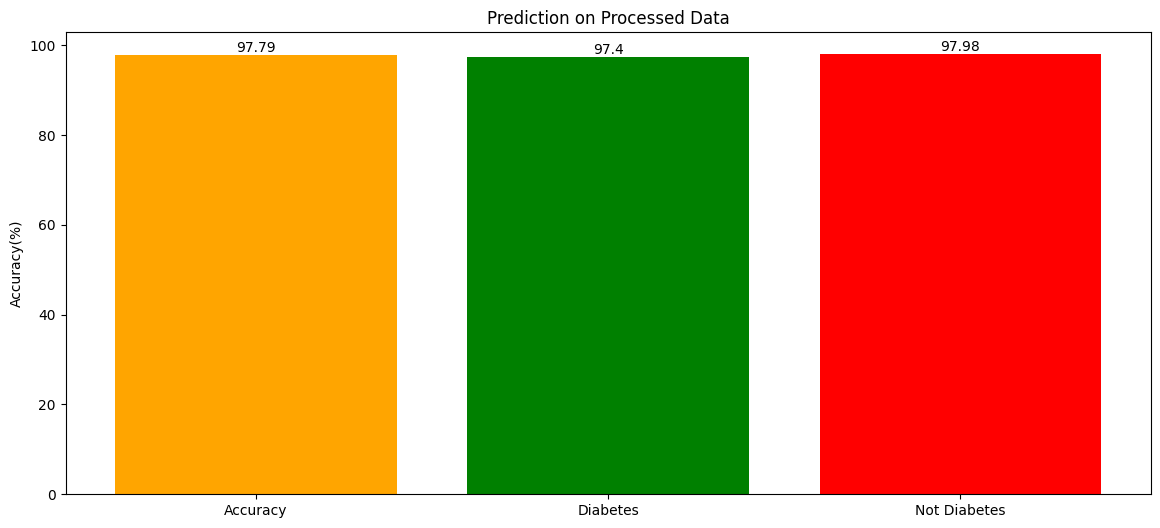

In [ ]:
y_proba = st.predict_proba(df_x)[:, 1]
y_pred = (y_proba >= 0.7).astype(int)

df['Prediction'] = y_pred
print(df)
accuracy = (((df['Prediction'] == df['Outcome']).sum()/df.shape[0])*100).round(2)
accuracy_1 = ((((df['Prediction']==1) & (df['Outcome']==1)).sum()/(df['Outcome']==1).sum())*100).round(2)
accuracy_0 = ((((df['Prediction']==0) & (df['Outcome']==0)).sum()/(df['Outcome']==0).sum())*100).round(2)

# Accuracy is float, need to put it in [] instead of keys(), values()
plt.figure(figsize=(14,6))
bar = plt.bar(['Accuracy'],[accuracy],color='orange')
plt.bar_label(bar)
bar_1 = plt.bar(['Diabetes'],[accuracy_1],color='green')
plt.bar_label(bar_1)
bar_0 = plt.bar(['Not Diabetes'],[accuracy_0],color='red')
plt.bar_label(bar_0)
plt.title('Prediction on Processed Data')
plt.ylabel('Accuracy(%)')
plt.show()

Raw Data

     Pregnancies  Glucose  BloodPressure  SkinThickness  Insulin   BMI  \
0              6      148             72             35        0  33.6   
1              1       85             66             29        0  26.6   
2              8      183             64              0        0  23.3   
3              1       89             66             23       94  28.1   
4              0      137             40             35      168  43.1   
..           ...      ...            ...            ...      ...   ...   
763           10      101             76             48      180  32.9   
764            2      122             70             27        0  36.8   
765            5      121             72             23      112  26.2   
766            1      126             60              0        0  30.1   
767            1       93             70             31        0  30.4   

     DiabetesPedigreeFunction  Age  Outcome  Prediction  
0                       0.627   50        1          

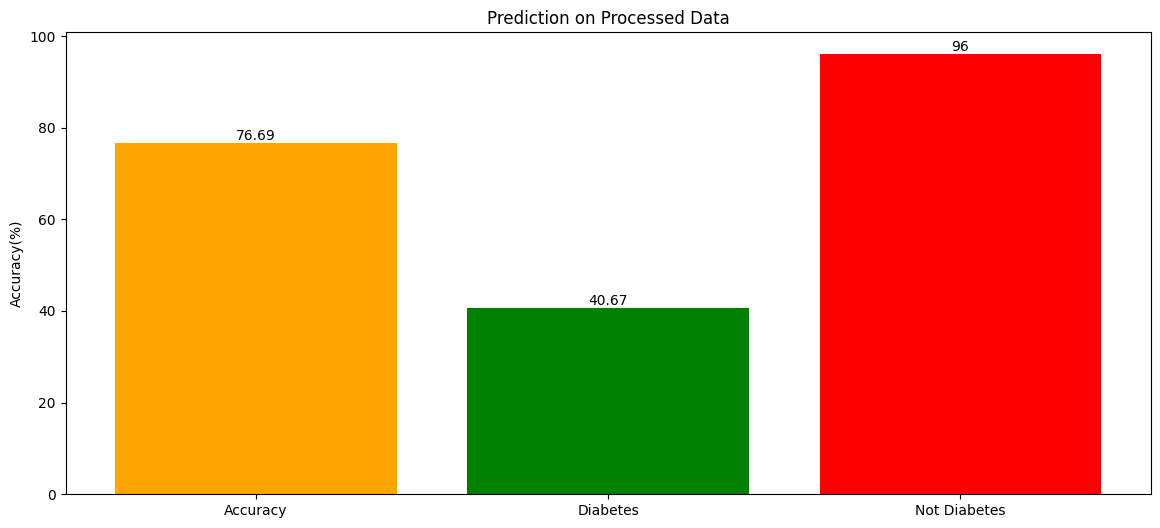

In [ ]:
y_proba = st.predict_proba(raw_x)[:, 1]
y_pred = (y_proba >= 0.7).astype(int)

dfCopy['Prediction'] = y_pred
print(dfCopy)
accuracy = (((dfCopy['Prediction'] == dfCopy['Outcome']).sum()/dfCopy.shape[0])*100).round(2)
accuracy_1 = ((((dfCopy['Prediction']==1) & (dfCopy['Outcome']==1)).sum()/(dfCopy['Outcome']==1).sum())*100).round(2)
accuracy_0 = ((((dfCopy['Prediction']==0) & (dfCopy['Outcome']==0)).sum()/(dfCopy['Outcome']==0).sum())*100).round(2)

# Accuracy is float, need to put it in [] instead of keys(), values()
plt.figure(figsize=(14,6))
bar = plt.bar(['Accuracy'],[accuracy],color='orange')
plt.bar_label(bar)
bar_1 = plt.bar(['Diabetes'],[accuracy_1],color='green')
plt.bar_label(bar_1)
bar_0 = plt.bar(['Not Diabetes'],[accuracy_0],color='red')
plt.bar_label(bar_0)
plt.title('Prediction on Processed Data')
plt.ylabel('Accuracy(%)')
plt.show()

Đánh giá/Cảm nghĩ:

*   Dự đoán lên Processed có mô hình RandomForest và mô hình tổ hợp Stacking đưa ra kết quả rất tốt, hiệu quả phân loại class 1 và class 0 đồng đều. Mô hình CatBoost dự đoán tốt ở việc phân loại class 1, nhưng rất tiếc cho class 0 và độ chính xác tổng quát lại không đạt hiệu quả cao, tốt như 2 mô hình còn lại.
*   Dự đoán lên tập dữ liệu Raw, tập dự đoán là một thử thách vì khác với tập dự liệu Processed, đây là tập dự đoán có giá trị ngoại lai và giá trị thiếu, mô hình không được huấn luyện cho các dữ liệu như thế này. Bởi vậy nên sẽ không cần thiết để đánh giá dự đoán lên Raw.
*   Sự tồn tại của dự đoán Raw là để đảm bảo rằng mô hình nhận diện đúng hướng đi. Cụ thể là mô hình chỉ nhận diện tốt trên tập dự đoán đã được xử lý qua các bước tương tự dữ liệu huấn luyện cho mô hình, phải dự đoán tệ lên tập dự đoán chưa qua tiền xử lý dữ liệu, đặc biệt là khi chúng có giá trị thiếu và ngoại lai.
*   Lưu ý một điều, nếu mô hình dự đoán rất tốt lên tập dữ liệu Raw, thì đây là điều đáng lo ngại, vì điều này chứng tỏ mô hình có hiệu suất không tốt, mọi chỉ số đánh giá trung bình và khả năng nhận diện dữ liệu chưa được thấy sẽ giảm nếu điều này xảy ra, đây là biểu hiện của hiện tượng Overfitting.